In [1]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib import cm
from jupyterthemes import jtplot
jtplot.style()

# Exercise 10

- Load the olivetti faces dataset, split it into training, validation and test set then cluster the images using kmeans. 
- Visualize the clusters, are the same faces in each cluster?

In [2]:
X, y = datasets.fetch_olivetti_faces(shuffle=True, return_X_y=True)

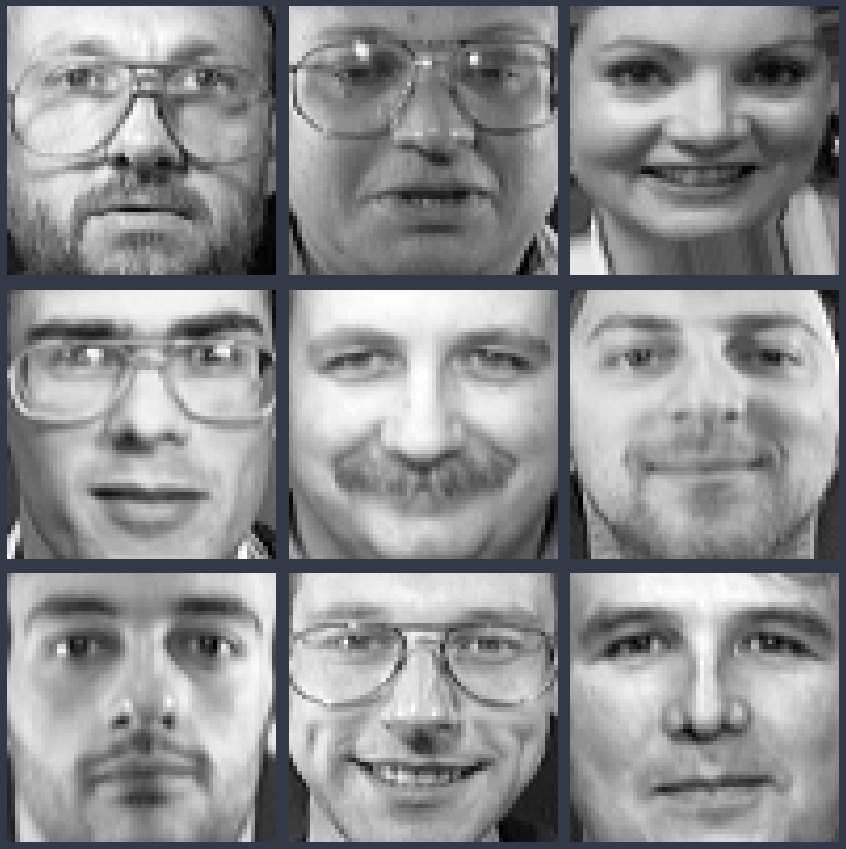

In [3]:
def plot_faces(X, nrows=3, ncols=3, title=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(12,12))
    for idx, ax in enumerate(axes.ravel()):
        ax.imshow(X[idx], cmap='gray')
        ax.axis('off')
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

imgs = X[:9].reshape(9, 64, 64)
plot_faces(imgs)

In [4]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.1, random_state=16, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=16, stratify=y_train_full)

In [5]:
k_range = range(5, 150, 5)
kmeans_list = [KMeans(n_clusters=k).fit(X_train) for k in k_range]
inertia_list = [km.inertia_ for km in kmeans_list]
silhouette_scores = [silhouette_score(X_train, km.labels_) for km in kmeans_list]

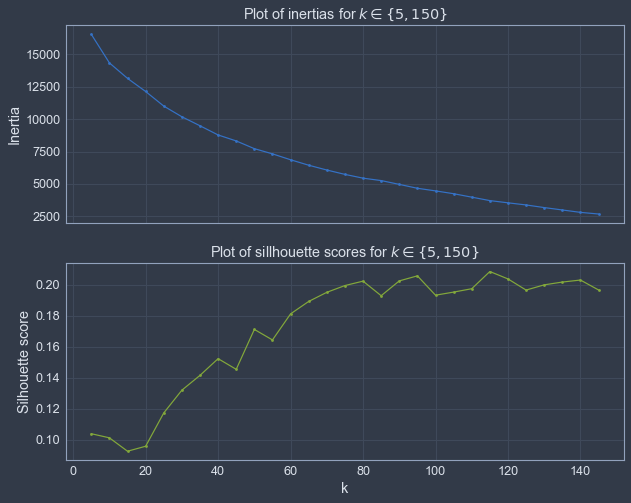

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(k_range, inertia_list, '.-')
ax1.set_xticklabels([])
ax1.set_ylabel("Inertia")
ax1.set_xlabel("")
ax1.set_title("Plot of inertias for $k\in  \{5, 150\}$")

ax2.plot(k_range, silhouette_scores, 'g.-')
ax2.set_ylabel("Silhouette score")
ax2.set_xlabel("k")
ax2.set_title("Plot of sillhouette scores for $k\in  \{5, 150\}$")
plt.show()

The plots for inertia don't show a clear elbow and the highest sillhouette score is obtained with k=115, let's use that

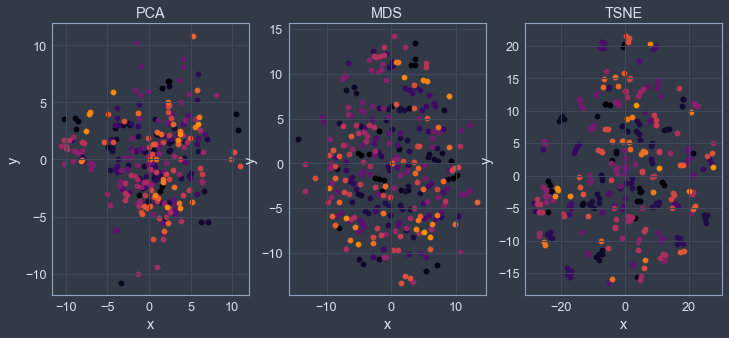

In [9]:
km = KMeans(n_clusters=115, n_init=20)
km.fit(X_train)
labels = km.labels_

reductions = [PCA(n_components=2), MDS(n_components=2), TSNE(n_components=2)]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
cmap_ = cm.get_cmap("inferno", 150)

for reduction, ax in zip(reductions, axes):
    X_reduced = reduction.fit_transform(X_train)
    
    for i in np.unique(labels):
        ax.scatter(
            X_reduced[labels==i, 0], X_reduced[labels==i, 1], color=cmap_(i), label=f'cluster {i}')
        
#     if reduction in reductions[:1]:
#             ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f"{type(reduction).__name__}")

Let's plot some faces from each cluster and see if they are similar

Cluster 0


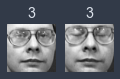

Cluster 1


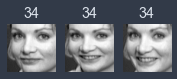

Cluster 2


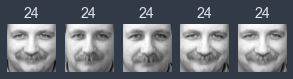

Cluster 3


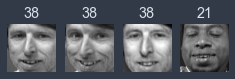

Cluster 4


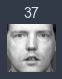

Cluster 5


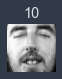

Cluster 6


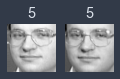

Cluster 7


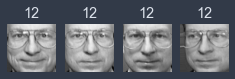

Cluster 8


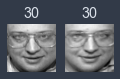

Cluster 9


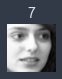

Cluster 10


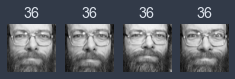

Cluster 11


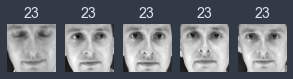

Cluster 12


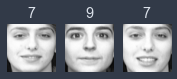

Cluster 13


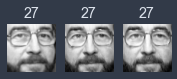

Cluster 14


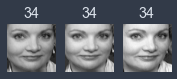

Cluster 15


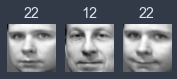

Cluster 16


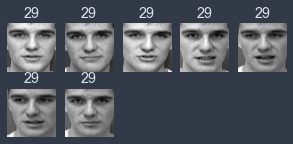

Cluster 17


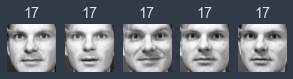

Cluster 18


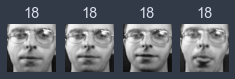

Cluster 19


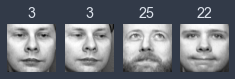

Cluster 20


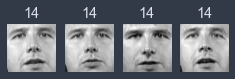

Cluster 21


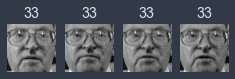

Cluster 22


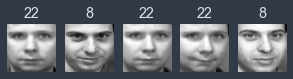

Cluster 23


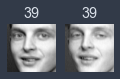

Cluster 24


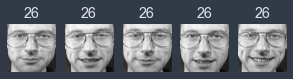

Cluster 25


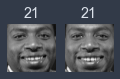

Cluster 26


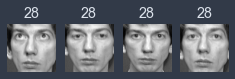

Cluster 27


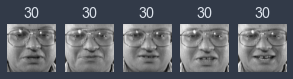

Cluster 28


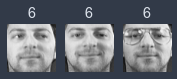

Cluster 29


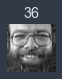

Cluster 30


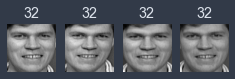

Cluster 31


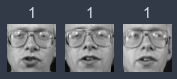

Cluster 32


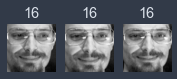

Cluster 33


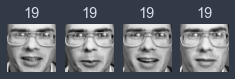

Cluster 34


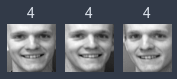

Cluster 35


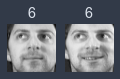

Cluster 36


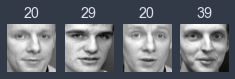

Cluster 37


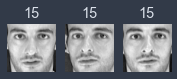

Cluster 38


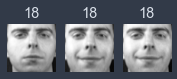

Cluster 39


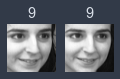

Cluster 40


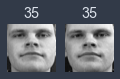

Cluster 41


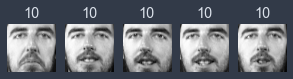

Cluster 42


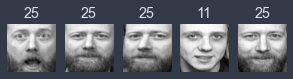

Cluster 43


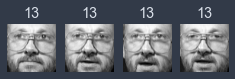

Cluster 44


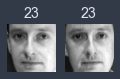

Cluster 45


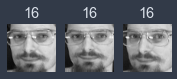

Cluster 46


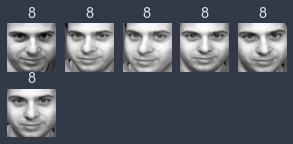

Cluster 47


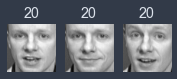

Cluster 48


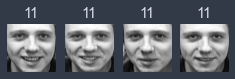

Cluster 49


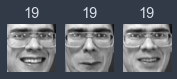

Cluster 50


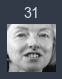

Cluster 51


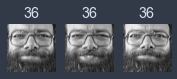

Cluster 52


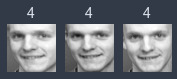

Cluster 53


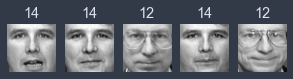

Cluster 54


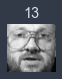

Cluster 55


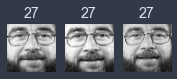

Cluster 56


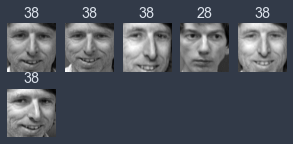

Cluster 57


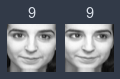

Cluster 58


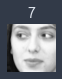

Cluster 59


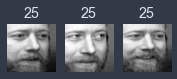

Cluster 60


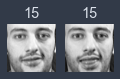

Cluster 61


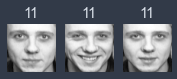

Cluster 62


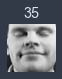

Cluster 63


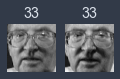

Cluster 64


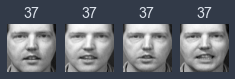

Cluster 65


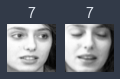

Cluster 66


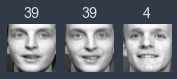

Cluster 67


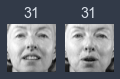

Cluster 68


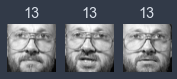

Cluster 69


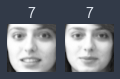

Cluster 70


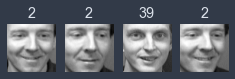

Cluster 71


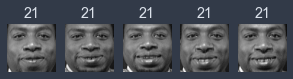

Cluster 72


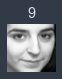

Cluster 73


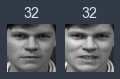

Cluster 74


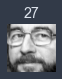

Cluster 75


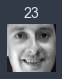

Cluster 76


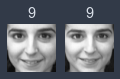

Cluster 77


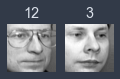

Cluster 78


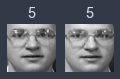

Cluster 79


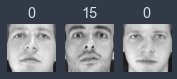

Cluster 80


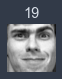

Cluster 81


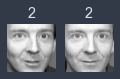

Cluster 82


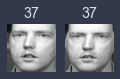

Cluster 83


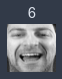

Cluster 84


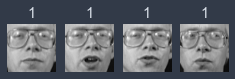

Cluster 85


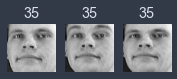

Cluster 86


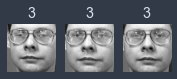

Cluster 87


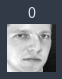

Cluster 88


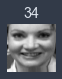

Cluster 89


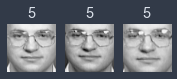

Cluster 90


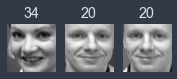

Cluster 91


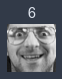

Cluster 92


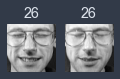

Cluster 93


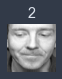

Cluster 94


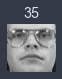

Cluster 95


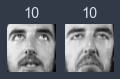

Cluster 96


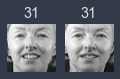

Cluster 97


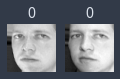

Cluster 98


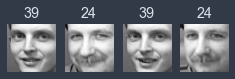

Cluster 99


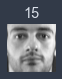

Cluster 100


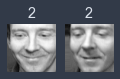

Cluster 101


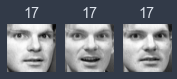

Cluster 102


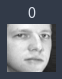

Cluster 103


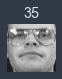

Cluster 104


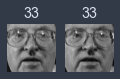

Cluster 105


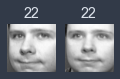

Cluster 106


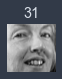

Cluster 107


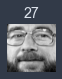

Cluster 108


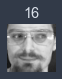

Cluster 109


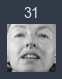

Cluster 110


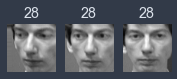

Cluster 111


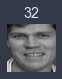

Cluster 112


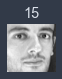

Cluster 113


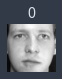

Cluster 114


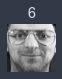

In [17]:
def plot_cluster_faces(imgs, labels, n_cols=5):
    n_rows = (len(imgs) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows *1.1))
    for idx, (img, cluster) in enumerate(zip(imgs, labels)):
        plt.subplot(n_rows, n_cols, idx+1)
        plt.imshow(img, cmap='gray')
        plt.axis("off")
        plt.title(cluster)
    plt.show()

for i in np.unique(labels):
    print("Cluster", i)
    imgs = X_train[labels==i].reshape(-1, 64, 64)
    plot_cluster_faces(imgs, y_train[labels==i])

Some of the clusters are really good, but it seems that as we go past cluster 99 the quality decreases (bar cluster 110) as well as the items get put into a single cluster, which is not useful.

# Exercise 11

- Train a classifier to predict which person is represented in each picture. Evaluate it on the validation set
- Use Kmeans as a dimensionality reduction tool and train a classifier on the reduced set. Search for the number of clusters that allows the classifier to get the best performance. 
- Try appending the features from the reduced set to the original features and re-evaluating the classifier

In [24]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings(action="ignore")  # supress sklearn warning

svc_param_grid = {
    "C": np.arange(0, 1, 0.1),
    "kernel": ["linear", "rbf"],
    "random_state": [17]}
svc_cv = GridSearchCV(SVC(), svc_param_grid, cv=5)
svc_cv.fit(X_train, y_train)
svc_clf = svc_cv.best_estimator_
print(f"SVC validation score: {svc_clf.score(X_valid, y_valid):.2%}")

forest_grid = {
    "n_estimators": range(70, 120, 10),
    "min_samples_split": range(2, 6),
    "random_state": [17],
    "n_jobs": [-1]}
rand_cv = GridSearchCV(RandomForestClassifier(), forest_grid, cv=5)
rand_cv.fit(X_train, y_train)
rand_clf = rand_cv.best_estimator_
print(f"RandomForest validation score: {rand_clf.score(X_valid, y_valid):.2%}")

log_grid = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": np.arange(0, 1, 0.1),
    "random_state": [17],
    "n_jobs": [-1]}
log_cv = GridSearchCV(LogisticRegression(), log_grid, cv=5)
log_cv.fit(X_train, y_train)
log_clf = log_cv.best_estimator_
print(f"LogisticRegression validation score: {log_clf.score(X_valid, y_valid):.2%}")

SVC validation score: 94.44%
RandomForest validation score: 85.19%
LogisticRegression validation score: 90.74%


Now for adding KMeans as a preprocessing step

In [45]:
from sklearn.pipeline import Pipeline

pipeline =  Pipeline([
    ("preprocessing", KMeans()),
    ("classifier", SVC(**svc_cv.best_params_))
])
param_grid = {"preprocessing__n_clusters": range(2, 100)}
pipeline_cv = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)
print(f"GridSearch found Kmeans with k={pipeline_cv.best_params_['preprocessing__n_clusters']} yielded best score")
print(f"SVC with KMeans validation score: {pipeline_cv.best_estimator_.score(X_valid, y_valid):.2%}")

Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed: 10.1min finished


GridSearch found Kmeans with k=92 yielded best score
SVC with KMeans validation score: 90.74%


Now let's use Kmeans to create new features and combine them with the original ones

In [67]:
n_clusters = pipeline_cv.best_params_["preprocessing__n_clusters"]

print(f"Preprocessing data with KMeans, k={n_clusters}")
best_km = KMeans(n_clusters=n_clusters, n_init=30)
X_train_km = best_km.fit_transform(X_train)
X_train_expanded = np.c_[X_train, X_train_km]
X_valid_expanded = np.c_[X_valid, best_km.transform(X_valid)]

print("Fitting models...")
svc_clf_2 = SVC(**svc_cv.best_params_)
svc_clf_2.fit(X_train_expanded, y_train)
print(f"SVC with additional features validation score: {svc_clf_2.score(X_valid_expanded, y_valid):.2%}")

rnd_clf_2 = RandomForestClassifier(**rand_cv.best_params_)
rnd_clf_2.fit(X_train_expanded, y_train)
print(f"RandomForest with additional features validation score: {rnd_clf_2.score(X_valid_expanded, y_valid):.2%}")

log_clf_2 = LogisticRegression(**log_cv.best_params_)
log_clf_2.fit(X_train_expanded, y_train)
print(f"LogisticRegression with additional features validation score: {log_clf_2.score(X_valid_expanded, y_valid):.2%}")

Preprocessing data with KMeans, k=92
Fitting models...
SVC with additional features validation score: 92.59%
RandomForest with additional features validation score: 88.89%
LogisticRegression with additional features validation score: 94.44%


It was effective adding the extra features, however I had to do a few runs of this cell to get better results. Now let's compare all models on the test set

In [72]:
models = [svc_clf, rand_clf, log_clf, svc_clf_2, rnd_clf_2, log_clf_2]
model_names = ["base_svc", "base_random_forest", "base_logistic_regression", "expanded_svc", "expanded_random_forest", "expanded_logistic_regression"]

X_test_expanded = np.c_[X_test, best_km.transform(X_test)]
for model, name in zip(models, model_names):
    X_test_print = X_test_expanded if name in model_names[-3:] else X_test
    print(f"{name} with test score: {model.score(X_test_print, y_test):.2%}")

base_svc with test score: 100.00%
base_random_forest with test score: 97.50%
base_logistic_regression with test score: 97.50%
expanded_svc with test score: 92.50%
expanded_random_forest with test score: 90.00%
expanded_logistic_regression with test score: 97.50%


# Exercise 12
- Train a GMM on the Olivetti faces dataset (use PCA preserving 99% of the variance to speed up the process)
- Generate some new faces using the fit GMM
- Modify some of the images (rotating, flipping, darkening) and check if the model can detect anomalies

In [18]:
pca = PCA(n_components=0.99)
X_train_reduced = pca.fit_transform(X_train_full)

First let's identify how many clusters GMM finds

In [20]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

k_range = range(1, 50)
gmm_per_k = [GaussianMixture(n_components=k, n_init=5).fit(X_train_reduced) for k in k_range]
aics = [model.aic(X_train_reduced) for model in gmm_per_k]
bics = [model.bic(X_train_reduced) for model in gmm_per_k]

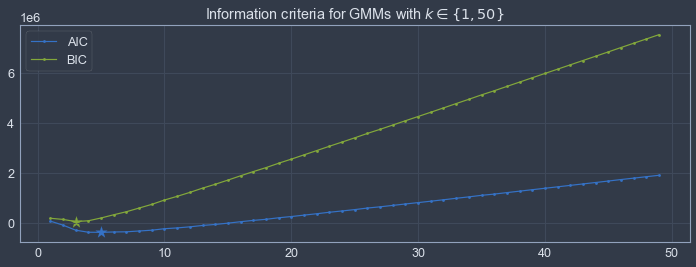

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(k_range, aics, '.-', label="AIC")
plt.plot(k_range, bics, '.-', label="BIC")
plt.scatter(np.argmin(aics)+1, np.min(aics), c='b', marker="*", s=150)
plt.scatter(np.argmin(bics)+1, np.min(bics), c='g', marker="*", s=150)
plt.title("Information criteria for GMMs with $k\in \{1, 50\}$")
plt.legend()
plt.show()

AIC indicates 5 clusters while BIC indicates 3. Let's try both and compare the appraoches.

In [25]:
gmm5 = GaussianMixture(n_components=5, n_init=10)
gmm5.fit(X_train_reduced)

gmm3 = GaussianMixture(n_components=3, n_init=10)
gmm3.fit(X_train_reduced)

GaussianMixture(n_components=3, n_init=10)

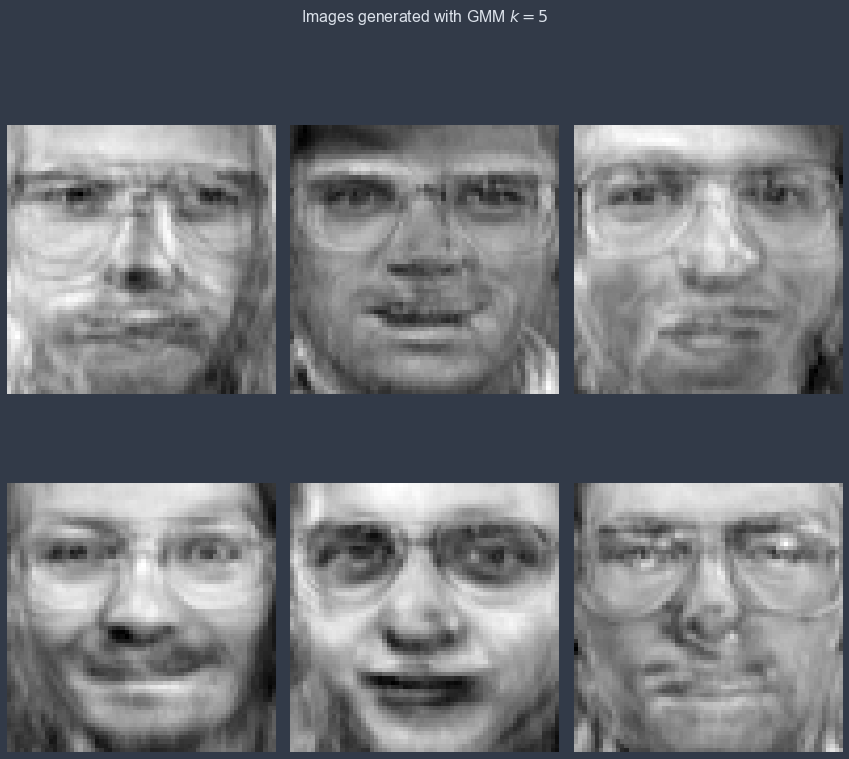

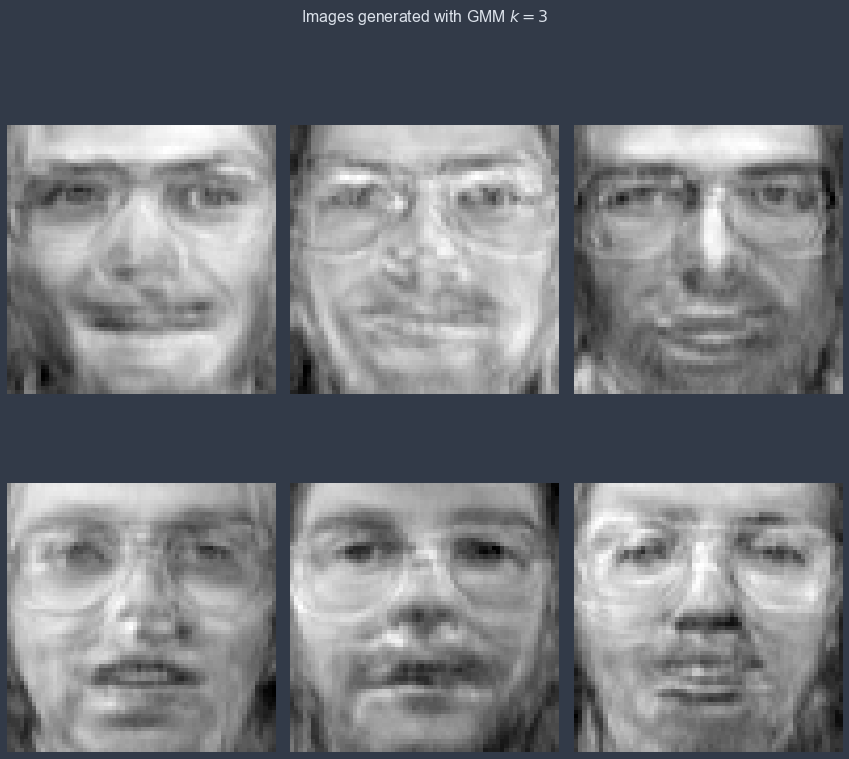

<Figure size 460.8x403.2 with 0 Axes>

In [26]:
gmm5_samples = pca.inverse_transform(gmm5.sample(6)[0]).reshape(6, 64, 64)
gmm3_samples = pca.inverse_transform(gmm3.sample(6)[0]).reshape(6, 64, 64)


plot_faces(gmm5_samples, 2, 3, title="Images generated with GMM $k=5$")
plot_faces(gmm3_samples, 2, 3, title="Images generated with GMM $k=3$")
plt.tight_layout()
plt.show()

The samples generated by both models are quite noisy and terrifying. Let's modify some images and see if the model identifies them as outliers

In [33]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2,  1])
rot_right = rotated.reshape(-1, 64*64)
rot_left = rotated.reshape(-1, 64*64)[:, ::-1]
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 4
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rot_right, rot_left, flipped, darkened]
y_bad_faces = np.concatenate([y_rotated, y_rotated, y_flipped, y_darkened])

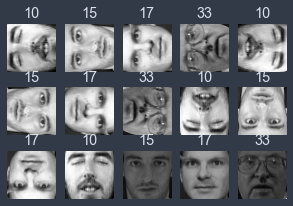

In [34]:
plot_cluster_faces(X_bad_faces.reshape(-1, 64, 64), y_bad_faces)

Now let's score them. The `score_samples` methods computes the weighted log probabilities for each sample

In [41]:
gmm5.score_samples(pca.transform(X_bad_faces))

array([-21291855.19704386, -18561465.04488509, -20213431.21514346,
        -8822364.58346363, -23120011.31944356, -16804991.98218968,
       -15406038.1082152 , -13633063.48261622, -18702613.42281466,
       -10529133.07747653, -10986851.57478797, -15649473.574872  ,
       -13560154.02806239, -11495444.52670414, -16683285.40257589])

And comparing them against the actual training data

In [42]:
gmm5.score_samples(X_train_reduced[:12])

array([1019.49640472,  862.27148747,  995.37656787,  862.26973417,
        862.26948311, 1016.70441257,  972.33052396,  972.33097578,
        862.26838398,  972.33068889,  995.3765592 , 1016.70475974])

The score for the modified images is much much smaller, indicating them mixture would ifentify them as outliers

# Exercise 13

Use PCA for anomaly detection:
- Reduce the olivetti faces preserving 99% of variance
- Compute reconstruction error for each image
- Take the modified images created in exercise 12 and compute their reconstruction error
- Plot the reconstructed modified images

In [48]:
def calc_reconstruction_error(pca, X):
    X_reduced = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_reduced)
    return np.square(X_reconstructed - X).mean(axis=-1)  # MSE

In [67]:
calc_reconstruction_error(pca, X_train[:15]).mean()

0.00019428115

In [51]:
calc_reconstruction_error(pca, X_bad_faces).mean()

0.0051223356

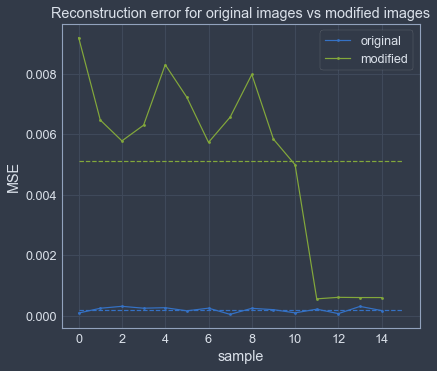

In [62]:
x_range = range(15)
original_mse = calc_reconstruction_error(pca, X_train[:15])
modified_mse = calc_reconstruction_error(pca, X_bad_faces)

plt.plot(x_range, original_mse, 'b.-', label="original")
plt.hlines(original_mse.mean(), 0, 15, 'b', 'dashed')
plt.plot(x_range, modified_mse, 'g.-', label="modified")
plt.hlines(modified_mse.mean(), 0, 15, 'g', 'dashed')
plt.legend()
plt.title("Reconstruction error for original images vs modified images")
plt.ylabel("MSE")
plt.xlabel("sample")
plt.show()

The reconstruction error is one order of magnetude higher which is very evident in the plot. Now let's see how the reconstructed faces look

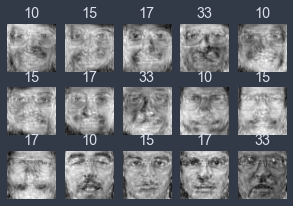

In [66]:
X_bad_reduced = pca.transform(X_bad_faces)
X_bad_reconstructed = pca.inverse_transform(X_bad_reduced).reshape(-1, 64, 64)
plot_cluster_faces(X_bad_reconstructed, y_bad_faces)

And comparing to what the original faces reconstructe

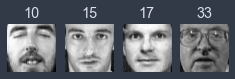

In [70]:
X_original_reduced = pca.transform(X_train[:4])
X_original_reconstructed = pca.inverse_transform(X_original_reduced).reshape(-1, 64, 64)
plot_cluster_faces(X_original_reconstructed, y_train[:4])